In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [40]:
from collections import OrderedDict
from random import sample
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    f1_score
)
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from tqdm.notebook import tqdm

from decision_tree_model import DecisionTreeModel



# Load data

In [3]:
df = pd.read_csv('data.csv')

In [5]:
df.sample(5)

,Age,workclass,Fnlwgt,Education,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,Money
7336,40,Private,220589,Some-college,10,Married-civ-spouse,Sales,Wife,White,Female,0,0,40,United-States,>50K
29306,31,Self-emp-not-inc,234537,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,60,United-States,<=50K
20373,28,Private,205337,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,<=50K
22019,20,Private,47678,HS-grad,9,Never-married,Craft-repair,Own-child,White,Male,0,0,40,United-States,<=50K
29187,31,Private,178370,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,0,99,United-States,>50K


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   Fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education-num   32561 non-null  int64 
 5   Marital-status  32561 non-null  object
 6   Occupation      32561 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital-gain    32561 non-null  int64 
 11  Capital-loss    32561 non-null  int64 
 12  Hours-per-week  32561 non-null  int64 
 13  Native-country  32561 non-null  object
 14  Money           32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


# Data preproccessing

Датасет довольно большой, для выполнения задания хватит 1000 строк.

In [7]:
df = df.sample(1000)

Удалим строки с `'?'`

In [8]:
idx_to_drop = []
obj_cols = ['workclass', 'Education', 'Marital-status', 'Occupation', 'Relationship', 
            'Race', 'Sex', 'Native-country', 'Money']
for idx, r in tqdm(df[obj_cols].iterrows()):
    f = 0
    for s in r:
        if '?' in s:
            f = 1
    if f == 1:
        idx_to_drop.append(idx)
            
print(len(idx_to_drop))

0it [00:00, ?it/s]

79


In [9]:
df.drop(index=idx_to_drop, inplace=True)

Разметим таргет

In [10]:
df['Money'] = (df['Money'] == " <=50K").astype('int64')

In [11]:
df.sample(5)

,Age,workclass,Fnlwgt,Education,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,Money
8986,20,Private,50397,Some-college,10,Married-civ-spouse,Sales,Husband,Black,Male,0,0,35,United-States,1
30812,22,Private,172766,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,40,United-States,1
16010,50,Private,166220,Assoc-acdm,12,Married-civ-spouse,Sales,Wife,White,Female,3942,0,40,United-States,1
5694,44,Private,182616,Assoc-voc,11,Married-civ-spouse,Tech-support,Husband,White,Male,0,0,40,United-States,0
11899,39,Private,167140,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,1


Класс не сбалансированы:

In [39]:
df.Money.value_counts()

1    706
0    215
Name: Money, dtype: int64

Остальные категориальные признаки кодируются при построении дерева через Label Encoding.

Train/test split

In [12]:
random_state = 42

X = df.drop(['Money'], axis=1)
y = df['Money']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state)

# Build & train custom decision tree

Обучим наше кастомное дерево, в котором используется критерий Джини.

In [13]:
tree = DecisionTreeModel(max_depth=5, min_node_size=20)
df_tree = tree.fit(X_train, y_train)

Закодированные категориальные признаки:

In [22]:
df_tree.sorted_cat_features

[[{' Self-emp-inc': 0,
   ' Federal-gov': 1,
   ' Self-emp-not-inc': 2,
   ' Local-gov': 3,
   ' State-gov': 4,
   ' Private': 5,
   ' Without-pay': 6},
  {' Doctorate': 0,
   ' Prof-school': 1,
   ' Masters': 2,
   ' Bachelors': 3,
   ' Assoc-voc': 4,
   ' Assoc-acdm': 5,
   ' 12th': 6,
   ' Some-college': 7,
   ' HS-grad': 8,
   ' 10th': 9,
   ' 7th-8th': 10,
   ' 11th': 11,
   ' 5th-6th': 12,
   ' Preschool': 13,
   ' 1st-4th': 14,
   ' 9th': 15},
  {' Married-civ-spouse': 0,
   ' Separated': 1,
   ' Divorced': 2,
   ' Widowed': 3,
   ' Never-married': 4,
   ' Married-spouse-absent': 5},
  {' Prof-specialty': 0,
   ' Exec-managerial': 1,
   ' Protective-serv': 2,
   ' Tech-support': 3,
   ' Transport-moving': 4,
   ' Sales': 5,
   ' Machine-op-inspct': 6,
   ' Craft-repair': 7,
   ' Farming-fishing': 8,
   ' Handlers-cleaners': 9,
   ' Adm-clerical': 10,
   ' Other-service': 11},
  {' Wife': 0,
   ' Husband': 1,
   ' Not-in-family': 2,
   ' Other-relative': 3,
   ' Unmarried': 4,
  

In [23]:
y_pred = tree.predict(X_test)

In [20]:
def classification_report(y_true, y_pred):
    print(f'Accuracy: \t{accuracy_score(y_true, y_pred)}')
    print(f'Precision:\t{precision_score(y_true, y_pred)}')
    print(f'Recall:   \t{recall_score(y_true, y_pred)}')
    print(f'F1-score: \t{f1_score(y_true, y_pred)}')

In [21]:
classification_report(y_test.to_numpy(), y_pred)

Accuracy: 	0.8223684210526315
Precision:	0.8913043478260869
Recall:   	0.8760683760683761
F1-score: 	0.8836206896551724


# Compare with decision tree from sklearn

In [25]:
le = LabelEncoder()
X_train_sk = X_train.apply(le.fit_transform)
X_test_sk = X_test.apply(le.fit_transform)

In [31]:
tree_sk = DecisionTreeClassifier(max_depth=5, min_samples_leaf=20, criterion='gini', random_state=random_state)
tree_sk.fit(X_train_sk, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=20, random_state=42)

In [32]:
y_pred_sk = tree.predict(X_test_sk)

In [33]:
classification_report(y_test, y_pred_sk)

Accuracy: 	0.6282894736842105
Precision:	0.8102564102564103
Recall:   	0.6752136752136753
F1-score: 	0.7365967365967366


При равных гиперпарметрах кастомное дерево показало лучший результат, чем дерево из Sklearn.

# Random Forest & OOB estimation

Поскольку работаем случайный лес, то возьмем деревья с большей глубиной, чем на прошлых этапах.

In [35]:
rf = RandomForestClassifier(n_estimators=100, max_depth=10, criterion='gini', random_state=42)
rf.fit(X_train_sk, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

In [37]:
y_pred_rf = rf.predict(X_test_sk)

In [38]:
classification_report(y_test, y_pred_rf)

Accuracy: 	0.8421052631578947
Precision:	0.8394160583941606
Recall:   	0.9829059829059829
F1-score: 	0.905511811023622


Лучший результат по F1-мере.

Сделаем оценку OOB

In [47]:
clfs = [("RF, max_features='log2'",
         RandomForestClassifier(warm_start=True, 
                                max_features='log2',
                                oob_score=True, 
                                random_state=random_state)
        ),
        ("RF, max_features=None",
         RandomForestClassifier(warm_start=True, 
                                max_features=None,
                                oob_score=True, 
                                random_state=random_state)
        )]


In [48]:
X_train_sk.shape

(617, 14)

In [49]:
errors = OrderedDict((label, []) for label, _ in clfs)
min_estimators, max_estimators = 10, 300

for label, clf in tqdm(clfs):
    for i in range(min_estimators, max_estimators + 1, 10):
        clf.set_params(n_estimators=i)
        clf.fit(X_train_sk, y_train)
        errors[label].append((i, 1 - clf.oob_score_))

  0%|          | 0/2 [00:00<?, ?it/s]

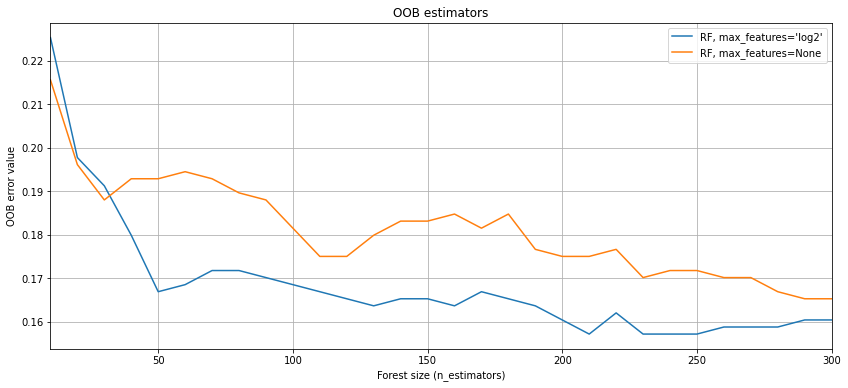

In [51]:
plt.figure(figsize=(14, 6))
plt.title('OOB estimators')
for label, clf_err in errors.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("Forest size (n_estimators)")
plt.ylabel("OOB error value")
plt.legend()
plt.grid()
plt.show()